# Finding 3's and 7's from our MNIST Dataset

In [4]:
from fastai.vision.all import *

download a sample of MNIST that contains images

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
Path.BASE_PATH = path

In [7]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set

In [8]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the labels (or targets) in this dataset.

In [9]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

In [10]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a NumPy array or a PyTorch tensor. For instance, here's what a section of the image looks like, converted to a NumPy array:

4:10 for rows: This means you are selecting rows from index 4 (inclusive) to index 10 (exclusive). So, it includes rows 4, 5, 6, 7, 8, and 9 (a total of 6 rows).

4:10 for columns: Similarly, this means you are selecting columns from index 4 (inclusive) to index 10 (exclusive). So, it includes columns 4, 5, 6, 7, 8, and 9 (a total of 6 columns).

In [11]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [12]:
# as a PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [13]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two.

how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to.

Let's create a tensor containing all of our 3s and 7s stacked together

In [14]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:

<Axes: >

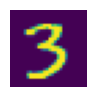

In [15]:
show_image(three_tensors[1])

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called *stack* that we can use for this purpose.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [16]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its shape. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels.

The length of a tensor's shape is its rank(the number of axes or dimensions in a tensor)

In [17]:
len(stacked_threes.shape)

3

We can also get a tensor's rank directly with ndim:

In [18]:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor.

<Axes: >

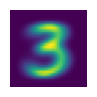

In [19]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

In [20]:
mean3.shape

torch.Size([28, 28])

In [21]:
mean3.ndim

2

<Axes: >

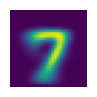

In [22]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

there are two main ways data scientists measure distance in this context:

Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*.
Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the *root mean squared error (RMSE)* or *L2 norm*.

<Axes: >

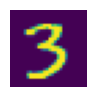

In [23]:
a_3 = stacked_threes[1]
show_image(a_3)

Let's try both of these now:

In [24]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [25]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Both metrics show that a_3 is closer to mean3 than to mean7

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [26]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here mse stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value (in math it's called the L1 norm).

### Numpy arrays and Pytorch tensors

Numpy arrays, unlike Pytorch tensors, does not support using the GPU or calculating gradients, which are both critical for deep learning. NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.

A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array."
A PyTorch tensor is nearly the same thing as a NumPy array, but cannot be jagged.

Python is slow compared to many languages. C language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to array() or tensor()

In [27]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [28]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [29]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

You can select a row (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

In [30]:
tns[1]

tensor([4, 5, 6])

or a column, by using : to indicate all of the first axis (we sometimes refer to the dimensions of tensors/arrays as axes):

In [31]:
tns[:,1]

tensor([2, 5])

Python slice syntax ([start:end] with end being excluded) to select part of a row or column:

In [32]:
tns[1,1:3]

tensor([5, 6])

And you can use the standard operators such as +, -, *, /:

In [33]:
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [34]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### Computing Metrics using Broadcasting

Recall that a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.

As we've discussed, we want to calculate our metric over a validation set. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called valid? That's what this directory is for!

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [35]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [36]:
valid_3_tens.ndim

3

We can write a simple function that calculates the mean absolute error.
.mean((-1, -2)): Computes the mean across the last two dimensions of the tensor.

-1 refers to the last dimension.

-2 refers to the second-to-last dimension.

In [37]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, valid_3_tens, which has a shape of [1010,28,28] representing 1,010 images. But there is a better way.

we pass each stacked images from our validation data and compare it to the stacked mean of our trained data

In [38]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1488, 0.1145, 0.1158,  ..., 0.1129, 0.1419, 0.1669]),
 torch.Size([1010]))

it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set).

The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

So in this case, PyTorch treats mean3, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. What shape would you expect this tensor to have? Try to figure it out yourself before you look at the answer below:

In [39]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't actually allocate any additional memory
It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

Next in *mnist_distance* we see *abs*. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise,

In [40]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Thanks to broadcasting, we can also test it on the full validation set of 3s:

In [41]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [42]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

Go to *Stochastic Gradient Descent (SGD) topic* after the above broadcasting topic

#### The MNIST Loss Function

We already have our independent variables *x* —these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using *view*, which is a PyTorch method that changes the shape of a tensor without changing its contents. *-1* is a special parameter to *view* that means "make this axis as big as necessary to fit all the data":

In [43]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use 1 for 3s and 0 for 7s:

In [44]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A *Dataset* in PyTorch is required to return a tuple of *(x,y)* when indexed. Python provides a *zip* function which, when combined with *list*, provides a simple way to get this functionality:

In [45]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [46]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

In [47]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [48]:
weights = init_params((28*28,1))

The function weights * pixels won't be flexible enough. You might remember from high school math that the formula for a line is *y=w*x+b; we still need the *b*. We'll initialize it to a random number too:

In [49]:
bias = init_params(1)

In neural networks, the *w* in the equation *y=w*x+b is called the *weights*, and the *b* is called the *bias*. Together, the weights and bias make up the *parameters*.

We can now calculate a prediction for one image:

In [50]:
(train_x[0]*weights.T).sum() + bias

tensor([-3.4661], grad_fn=<AddBackward0>)

While we could use a Python *for loop* to calculate the prediction for each image, that would be very slow. In this case, there's an extremely convenient mathematical operation that calculates w*x for every row of a matrix—it's called *matrix multiplication*.

In Python, matrix multiplication is represented with the *@* operator. Let's try it:

In [51]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -3.4661],
        [  2.1309],
        [ -1.8237],
        ...,
        [-14.3697],
        [-13.6408],
        [  5.2929]], grad_fn=<AddBackward0>)

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!)

In [52]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [ True],
        [False],
        ...,
        [ True],
        [ True],
        [False]])

In [53]:
corrects.float().mean().item()

0.7135366201400757

Now let's see what the change in accuracy is for a small change in one of the weights (note that we have to ask PyTorch not to calculate gradients as we do this, which is what with *torch.no_grad()* is doing here):

In [54]:
with torch.no_grad(): weights[0] *= 1.0001

In [55]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.7135366201400757

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some loss function that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: *(y_new - y_old) / (x_new - x_old)*. This gives us a good approximation of the gradient when *x_new* is very similar to *x_old*, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from *x_old* to *x_new* isn't likely to cause any prediction to change, so *(y_new - y_old)* will almost always be 0. In other words, the gradient is 0 almost everywhere.

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number. In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now.

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, *prds*, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the *targets* (aka *labels*). Let's make another argument, trgts, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence *(0.9)* that the first was a 3, with slight confidence *(0.4)* that the second was a 7, and with fair confidence *(0.2)*, but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [56]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between *predictions* and *targets*:

In [57]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, *torch.where(a,b,c)*. This is the same as running the list comprehension *[b[i] if a[i] else c[i] for i in range(len(a))]*, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

Let's try it on our prds and trgts:

In [58]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, *mnist_loss* takes the mean of the previous tensor:

In [59]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from *0.2* to *0.8* the loss will go down, indicating that this is a better prediction:

In [60]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.